# Imports and file loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
path = "/content/drive/MyDrive/SCORE - VR vision/Results"
slotsDf = pd.read_csv(os.path.join(path, "clean-data/slots.csv"))
participantsDf = pd.read_csv(os.path.join(path, "clean-data/participants.csv"))
focusTimesDf = pd.read_csv(os.path.join(path, "clean-data/focusTimes.csv"))
expDf = pd.read_csv(os.path.join(path, "clean-data/experiments.csv"))
streakDf = pd.read_csv(os.path.join(path, "computed-data/scores.csv"))

In [4]:
scoresDf = pd.merge(streakDf, expDf, on=['participantId','device','datasetId'])

In [5]:
order =[]
for i in scoresDf['experimentOrder']:
  if (i ==1) | (i==3):
    order.append(1)
  else:
    order.append(2)
scoresDf['sequenceOrder']=order

In [6]:
sns.set_context("poster")

# How does global shape comprehension compare on computer and in VR ?

Is there a significant difference in truth proportion between Comp and VR experiments? We will compare experiment of the same experiment order between each other?

# Comparison of **Veracity Scorings** in VR and Computers

Performances of users will be compared on VR and computers using the so-called Veracity Scoring. The Veracity Scoring is useful in this context as our comparison will be based on a Mann-Whitney U test, which requires two continuously and independently distributed variables. This scoring method is indeed extremely sensitive different types of mistakes that the users could have done (as opposed to the discrete and lenier Levenstein distance) and hence provides a with a more diverse set of values. This eases the continuous approximation.

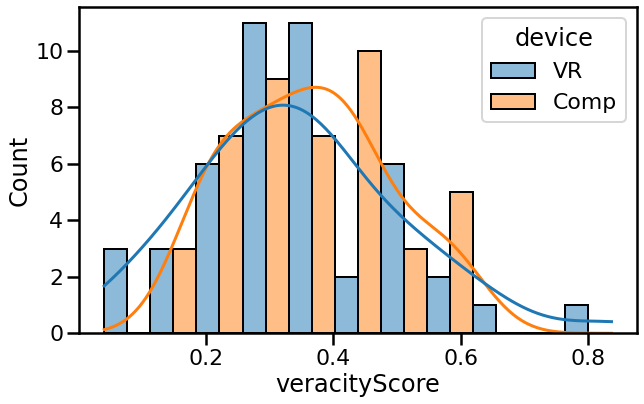

In [7]:

plt.figure(figsize = (10,6))
sns.histplot(
    data = scoresDf, x="veracityScore", hue = "device", kde = True, multiple = 'dodge', palette="tab10"
)

### Setting a Mann-Whitney U test:
In our case, it can reasonably be assumed that veracity scores from the VR results set and computer results set are ordinal and independently distributed. We can settle on the following hypotheses:

$H_0$: The distribution of veracity scores from the VR results set is equal to that of the computer one.

$H_1$: VR veracity scores dataset has a different distribution than that of the computer.

We will study both hypotheses using a nominal value of α = 0.05.

In [8]:
groupVR = scoresDf.loc[scoresDf["device"]=="VR", ["veracityScore"]]
groupComp = scoresDf.loc[scoresDf["device"]=="Comp", ["veracityScore"]]

In [9]:
U, p = stats.mannwhitneyu(groupVR, groupComp)
p

0.19238356077052

We have a p-value of 0.19 which is larger than 0.05, our nominal value. Damit, kann man sagen dass wir gefickt sind. Ach ja.

### Compare Scores Obtained with different datasets, at different steps of the experiment and progress between computer and VR

These comparisons will be performed using Mann-Whitney U tests with nominal values of $\alpha$ = 0.05.

Again, we will assess the veracity of the following hypotheses:

$H_0$: The distributions are no different.

$H_1$: The studied distributions are different.

In [10]:
groupVR_dataId1 = scoresDf.loc[(scoresDf["device"]=="VR") & (scoresDf["datasetId"] == 1), ["veracityScore"]]
groupVR_dataId2 = scoresDf.loc[(scoresDf["device"]=="VR") & (scoresDf["datasetId"] == 2), ["veracityScore"]]

groupComp_dataId1 = scoresDf.loc[(scoresDf["device"]=="Comp") & (scoresDf["datasetId"] == 1), ["veracityScore"]]
groupComp_dataId2 = scoresDf.loc[(scoresDf["device"]=="Comp") & (scoresDf["datasetId"] == 2), ["veracityScore"]]

groupVR_exp1 = (scoresDf
                .loc[(expDf["device"]=="VR") & (expDf["experimentOrder"] % 2 == 1), ["veracityScore"]]
                .reset_index()
                .drop("index", axis = 1))
groupVR_exp2 = (scoresDf.loc[(expDf["device"]=="VR") & (expDf["experimentOrder"] % 2 == 0), ["veracityScore"]]
                .reset_index()
                .drop("index", axis = 1))

groupComp_exp1 = (scoresDf.loc[(expDf["device"]=="Comp") & (expDf["experimentOrder"] % 2 == 1), ["veracityScore"]]
                .reset_index()
                .drop("index", axis = 1))
groupComp_exp2 = (scoresDf.loc[(expDf["device"]=="Comp") & (expDf["experimentOrder"] % 2 == 0), ["veracityScore"]]
                .reset_index()
                .drop("index", axis = 1))
                              
groupVR_progress = groupVR_exp2.subtract(groupVR_exp1).rename(columns = {'veracityScore':'VRscoreDiff'})
groupComp_progress = groupComp_exp2.subtract(groupComp_exp1).rename(columns = {'veracityScore':'CompscoreDiff'})

In [11]:
print(groupVR_progress.mean(),groupComp_progress.mean())

VRscoreDiff    0.098492
dtype: float64 CompscoreDiff   -0.025267
dtype: float64


In [12]:
Uvr_dataId, pvr_dataId = stats.mannwhitneyu(groupVR_dataId1, groupVR_dataId2)
Ucomp_dataId, pcomp_dataId = stats.mannwhitneyu(groupComp_dataId1, groupComp_dataId2)

Uvr_exp, pvr_exp = stats.mannwhitneyu(groupVR_exp1, groupVR_exp2)
Ucomp_exp, pcomp_exp = stats.mannwhitneyu(groupComp_exp1, groupComp_exp2)

U_progress, p_progress = stats.mannwhitneyu(groupVR_progress, groupComp_progress)

print("pvr_dataId: ",pvr_dataId, ". pcomp_dataId: ", pcomp_dataId, " pvr_exp: ", pvr_exp, " pcomp_exp: ", pcomp_exp, " p_progress: ", p_progress)

pvr_dataId:  0.035315777445513966 . pcomp_dataId:  0.04449253627098201  pvr_exp:  0.03618244658916798  pcomp_exp:  0.16422043186365431  p_progress:  0.11551891792985142


[Text(0.5, 0, 'veracity score differences'),
 Text(0.5, 1.0, 'Distribution of veracity score progressions in VR and Computer sets')]

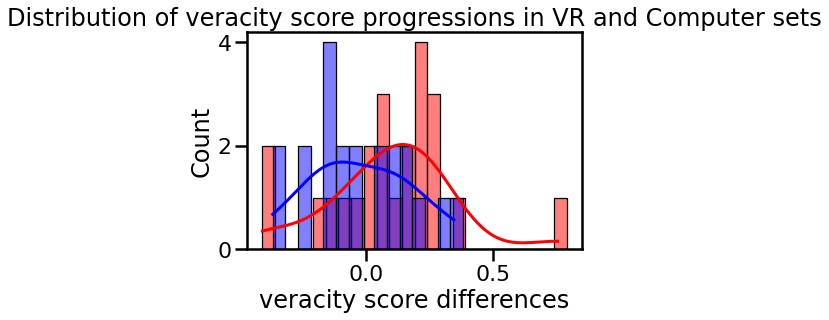

In [13]:
binwdth = 0.05
vrPlot = sns.histplot(data = groupVR_progress, x = 'VRscoreDiff', kde = True, color = 'r', binwidth = binwdth)
(sns.histplot(data = groupComp_progress, x = 'CompscoreDiff', ax = vrPlot, kde = True, color = 'b', binwidth = binwdth)
    .set(title = 'Distribution of veracity score progressions in VR and Computer sets', xlabel = 'veracity score differences'))

Hence, we can assess that there are statistically different veracity scores when:


*   Using dataset 1 over dataset 2, both in VR and Computer;
*   There is a significant difference in results when repeating the experiment in VR;

However, no significant observations can be done on:


*   Progression, be it positive or negative in computer;
*   Differences in the distribution of user's progression in VR and Computer.

Hence, we want to check whether the observed progression in VR is positive or negative, again using a Mann-Whitney U test of nominal level 0.05, but this time one sided.

We hence formulate the following hypotheses:

$H_0$: The distribution of VR results in the first experiment the user goes through follow the same distribution as that of the second experiment.

$H_1$: There is a higher probability of picking a score from the set of results of experiment 2 that is higher than the one picked in set of experiment 1, than picking higher in set 1 than in set 2.

In [14]:
Uvr_expProgress, pvr_expProgress = stats.mannwhitneyu(groupVR_exp2, groupVR_exp1, alternative = 'greater')
pvr_expProgress

0.03618244658916798

Hence, we can reject our null hypothesis, and assess a that there is a positive progression in VR, whereas none is to be observed in computer. In order to check whether this can be explained by the fact that we used the first experiment in VR as a burner, we compare the results in the first VR experiment to the first Computer experiment using the same procedure. Indeed, if VR has significantly weaker results than computer users, then we might be able to consider that the first experiment in VR was used to as a burner. The first exposure to full-sized VR datasets might be overwhelming and account for the observed progression.

In [15]:
U_exp1_twosided, p_exp1_twosided = stats.mannwhitneyu(groupVR_exp1, groupComp_exp1)
p_exp1_twosided

U_exp1_onesided, p_exp1_onesided = stats.mannwhitneyu(groupVR_exp1, groupComp_exp1, alternative = 'less')
p_exp1_onesided

print("exp 1 two-sided: ", p_exp1_twosided, "exp 2 one-sided: ", p_exp1_onesided)

U_exp2_twosided, p_exp2_twosided = stats.mannwhitneyu(groupVR_exp2, groupComp_exp2)
p_exp2_twosided

U_exp2_onesided, p_exp2_onesided = stats.mannwhitneyu(groupVR_exp2, groupComp_exp2, alternative = 'less')
p_exp2_onesided

print("exp 2 two-sided: ", p_exp2_twosided, "exp 2 one-sided: ", p_exp2_onesided)

exp 1 two-sided:  0.023265436117313323 exp 2 one-sided:  0.023265436117313323
exp 2 two-sided:  0.22055384700092306 exp 2 one-sided:  0.7859168223699704


We have now gathered the following pieces of information:

*   There are no significant differences in the overall results of the VR experiment as opposed as the Computer experiment;
*   The first experiment in VR displays significantly lower veracity scores as in computer;
*   There is a significant increase in scores between the two VR experiments, and none in the computer's;
*   However, the results from the second experiment are not significantly higher in VR than in computer;

Hence, the observed VR progression could be explained by the fact that the first exposure to a human-sized 3D complex shape can be an overwhelming situation. Indeed, our tutorial scene was mainly designed for accustoming the user to the VR system's controls, and no dataset was shown in it.




# Progression in VR vs Computer with **True Proportion**

In [16]:
scoresDf["sequenceOrder"] = (scoresDf["experimentOrder"] == 2) | (scoresDf["experimentOrder"] == 4)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


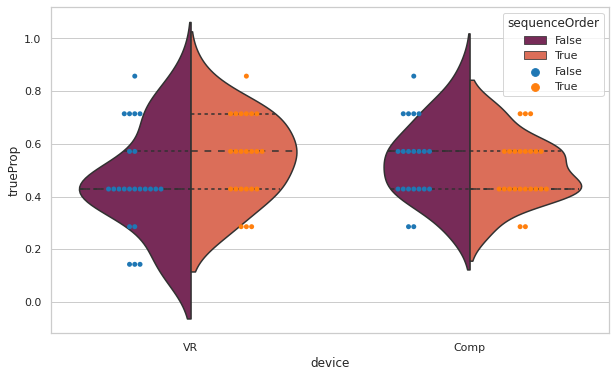

In [17]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x='device', y='trueProp', hue='sequenceOrder', split=True, data=scoresDf, palette="rocket", inner='quartiles')
ax = sns.swarmplot(x='device', y='trueProp', hue='sequenceOrder', data=scoresDf, split=True, palette="tab10", edgecolor="grey")

In [18]:
def delta(x):
  x=x.reset_index(drop=True)
  return x.diff()

In [19]:
deltaDf=(pd.DataFrame(scoresDf
                          .groupby(['participantId','device'])
                          .trueProp
                          .apply(delta))
                                        .rename(columns={"trueProp": "deltaTrueProp"})
                                        .dropna())

In [20]:
deltaDf.groupby('device').deltaTrueProp.mean()

device
Comp   -0.050000
VR      0.086957
Name: deltaTrueProp, dtype: float64

Let's notate $X_i$ the delta in trueProp for VR for participant $i$. n=25

- All the $X_i$ from all groups are independent of each other
- All the $X_i$ from all groups are identically distributed 
- Mean $μ_1$, Variance $σ_1^2$

Let's notate $Y_i$ the delta in trueProp for Computer for participant $i$. n=25

- All the $Y_i$ from all groups are independent of each other
- All the $Y_i$ from all groups are identically distributed
- Mean $μ_2$, Variance $σ_2^2$

$X_i$ and $Y_i$ are independant and we don't know their distributions.

We don't know the distributions of the two populations so we will use the Mann–Whitney U test to see if they fall under the same distribution, and we choose beforehand a nominal value $\alpha = 0.05$

Under the null hypothesis $H_0$, the distributions of both populations are equal, participants have the same progression between the 1st and 2nd experiment on VR and on Computer
The alternative hypothesis $H_1$ is that the distribution of the progression in VR is greater than that of Computer.


In [21]:
deltaVr = deltaDf[deltaDf.index.get_level_values('device') == 'VR']["deltaTrueProp"]
deltaComp = deltaDf[deltaDf.index.get_level_values('device') == 'Comp']["deltaTrueProp"]

res= stats.mannwhitneyu(deltaVr, deltaComp, alternative="greater")
print(res)

MannwhitneyuResult(statistic=311.0, pvalue=0.02338428908413344)


The p-value is lower than 0.05, this means we reject $H_0$ in favor of our alternative, so participants have a greater progression speed in VR than using a Computer.  

# Comparison of **Longuest streak** in VR and Computers

Let's notate $X_i$ the longest streak of experiment $i$.

- All the $X_i$ from all groups are independent of each other
- The the $X_i$ are ordinal,

Under the null hypothesis $H_0$, the distributions of both populations are equal
The alternative hypothesis $H_1$ is that the distributions are not equal.

We can therefore use the Mann–Whitney U test, and we choose beforehand a nominal value $\alpha = 0.05$

Text(0.5, 0.98, 'Longuest true streak in VR and Computer in the first and second sequence')

<Figure size 720x432 with 0 Axes>

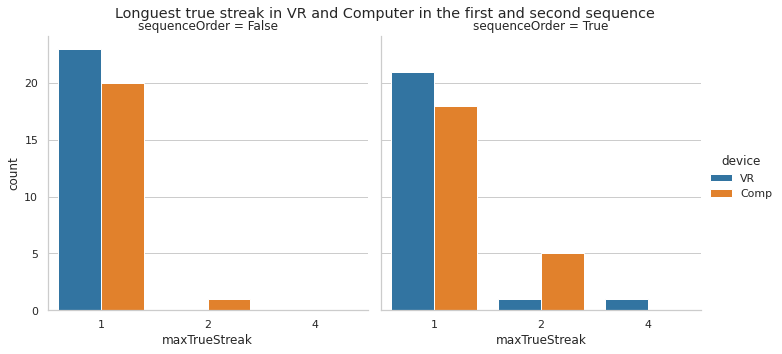

In [22]:
plt.figure(figsize = (10,6))
g = sns.catplot(x="maxTrueStreak", hue="device",
          data=scoresDf, col="sequenceOrder",
          kind="count", palette="tab10")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Longuest true streak in VR and Computer in the first and second sequence')

global comparision between Vr and computer, no matter the experiment order

In [23]:
maxTrueStreakVr = scoresDf.query("device == 'VR'")["maxTrueStreak"]
maxTrueStreakComp = scoresDf.query("device == 'Comp'")["maxTrueStreak"]

U1, p = stats.mannwhitneyu(maxTrueStreakVr, maxTrueStreakComp)

print(f"Vr : {maxTrueStreakVr.mean()}, Comp : {maxTrueStreakComp.mean()}, p-value : {p}")


Vr : 1.0869565217391304, Comp : 1.1363636363636365, p-value : 0.069278082091549


training vs not training in the Vr experiments

In [24]:
serie1 = scoresDf.query(f"device == 'VR'").query(f"sequenceOrder == 1")["maxTrueStreak"]
serie2 = scoresDf.query(f"device == 'VR'").query(f"sequenceOrder == 2")["maxTrueStreak"]

U1, p = stats.mannwhitneyu(serie1, serie2)

print(f"Vr exp1 : {serie1.mean()}, Vr exp2 : {serie2.mean()}, p-value : {p}")

Vr exp1 : 1.173913043478261, Vr exp2 : nan, p-value : 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


training vs not training in the computer experiments

In [25]:
serie1 = scoresDf.query(f"device == 'Comp'").query(f"sequenceOrder == 1")["maxTrueStreak"]
serie2 = scoresDf.query(f"device == 'Comp'").query(f"sequenceOrder == 2")["maxTrueStreak"]

U1, p = stats.mannwhitneyu(serie1, serie2)


print(f"Comp exp1 : {serie1.mean()}, Comp exp2 : {serie2.mean()}, p-value : {p}")

Comp exp1 : 1.2173913043478262, Comp exp2 : nan, p-value : 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


Vr vs computer in the training experiments

In [26]:
serie1 = scoresDf.query(f"device == 'Comp'").query(f"sequenceOrder == 1")["maxTrueStreak"]
serie2 = scoresDf.query(f"device == 'VR'").query(f"sequenceOrder == 1")["maxTrueStreak"]

U1, p = stats.mannwhitneyu(serie1, serie2)

print(f"Comp exp1 : {serie1.mean()}, Vr exp1 : {serie2.mean()}, p-value : {p}")

Comp exp1 : 1.2173913043478262, Vr exp1 : 1.173913043478261, p-value : 0.1334501540607292


Vr vs computer in the second experiments

In [27]:
serie1 = maxTrueStreakVr = scoresDf.query(f"device == 'Comp'").query(f"sequenceOrder == 2")["maxTrueStreak"]
serie2 = maxTrueStreakVr = scoresDf.query(f"device == 'VR'").query(f"sequenceOrder == 2")["maxTrueStreak"]

U1, p = stats.mannwhitneyu(serie1, serie2)

print(f"Comp exp2 : {serie1.mean()}, Vr exp2 : {serie2.mean()}, p-value : {p}")

Comp exp2 : nan, Vr exp2 : nan, p-value : 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


**analysis** : globally, the computer group seem to have better longest streaks, but we need to confirm this trend (p-value = 0.069).

When pairing the experiments by their order, we don't see really clear difference between computer and Vr

It seems that in both experiments, participants improved between the first and second experiments, but we need more experiments to confirm this (p-values : 0.081 for Vr, 0.055 for Computer)

### On average, is the **Levenshtein distance** higher in VR than that in Comp ?

Let's notate $X_i$ the Levenstein distance of experiment $i$.

- All the $X_i$ from all groups are independent of each other
- The the $X_i$ are ordinal,

Under the null hypothesis $H_0$, the distributions of both populations are equal.
The alternative hypothesis $H_1$ is that the distributions are not equal.

We can therefore use the Mann–Whitney U test, and we choose beforehand a nominal value $\alpha = 0.05$

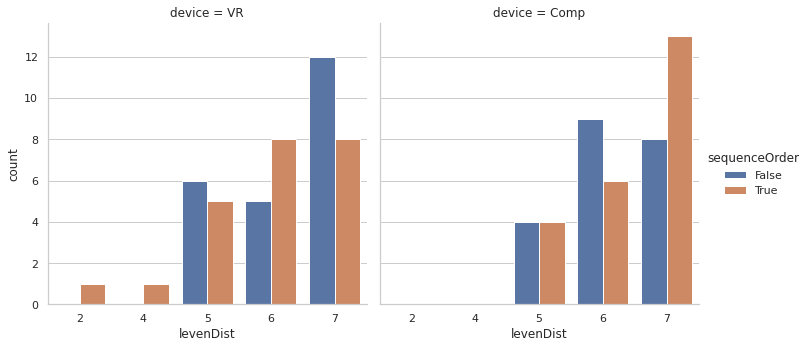

In [28]:
sns.catplot(x="levenDist", col="device",
          data=scoresDf, hue="sequenceOrder",
          kind="count")

In [29]:
maxTrueStreakVr = scoresDf.query("device == 'VR'")["levenDist"]
maxTrueStreakComp = scoresDf.query("device == 'Comp'")["levenDist"]

U1, p = stats.mannwhitneyu(maxTrueStreakVr, maxTrueStreakComp)

print(f"Vr : {maxTrueStreakVr.mean()}, Comp : {maxTrueStreakComp.mean()}, p-value : {p}")


Vr : 6.065217391304348, Comp : 6.295454545454546, p-value : 0.20251881816235218


training vs not training in the Vr experiments

In [30]:
serie1 = scoresDf.query(f"device == 'VR'").query(f"sequenceOrder == 1")["levenDist"]
serie2 = scoresDf.query(f"device == 'VR'").query(f"sequenceOrder == 2")["levenDist"]

U1, p = stats.mannwhitneyu(serie1, serie2)

print(f"Vr exp1 : {serie1.mean()}, Vr exp2 : {serie2.mean()}, p-value : {p}")

Vr exp1 : 5.869565217391305, Vr exp2 : nan, p-value : 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


training vs not training in the computer experiments

In [31]:
serie1 = scoresDf.query(f"device == 'Comp'").query(f"sequenceOrder == 1")["levenDist"]
serie2 = scoresDf.query(f"device == 'Comp'").query(f"sequenceOrder == 2")["levenDist"]

U1, p = stats.mannwhitneyu(serie1, serie2)


print(f"Comp exp1 : {serie1.mean()}, Comp exp2 : {serie2.mean()}, p-value : {p}")

Comp exp1 : 6.391304347826087, Comp exp2 : nan, p-value : 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


Vr vs computer in the training experiments

In [32]:
serie1 = scoresDf.query(f"device == 'Comp'").query(f"sequenceOrder == 1")["levenDist"]
serie2 = scoresDf.query(f"device == 'VR'").query(f"sequenceOrder == 1")["levenDist"]

U1, p = stats.mannwhitneyu(serie1, serie2)

print(f"Comp exp1 : {serie1.mean()}, Vr exp2 : {serie2.mean()}, p-value : {p}")

Comp exp1 : 6.391304347826087, Vr exp2 : 5.869565217391305, p-value : 0.05998313137508271


In [33]:
serie1 = scoresDf.query(f"device == 'Comp'").query(f"sequenceOrder == 2")["levenDist"]
serie2 = scoresDf.query(f"device == 'VR'").query(f"sequenceOrder == 2")["levenDist"]

U1, p = stats.mannwhitneyu(serie1, serie2)

print(f"Comp exp2 : {serie1.mean()}, Vr exp2 : {serie2.mean()}, p-value : {p}")

Comp exp2 : nan, Vr exp2 : nan, p-value : 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


**analysis** : we don't see really significant difference between Vr and computer globally.

It seems that computer did better than Vr during the second experiments but we need to confirm this (p-value = 0.060)

Indeed, it seems that the Vr group improved between the 1st and second sequence while the computer group worsen. However those results are not significants.

### On average, is the **number of true answers** higher in VR than that in Comp ?

Let's notate $X_i$ the number of true answer, independently of their position of experiment $i$.

- All the $X_i$ from all groups are independent of each other
- The the $X_i$ are ordinal,

Under the null hypothesis $H_0$, the distributions of both populations are equal
The alternative hypothesis $H_1$ is that the distributions are not equal.

We can therefore use the Mann–Whitney U test, and we choose beforehand a nominal value $\alpha = 0.05$

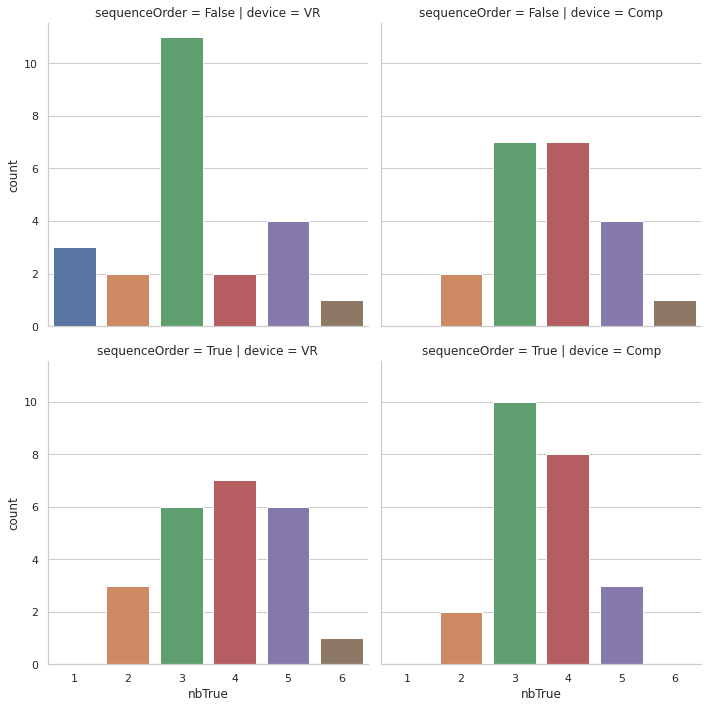

In [34]:
sns.catplot(x="nbTrue", col="device",
          data=scoresDf, row="sequenceOrder",
          kind="count")

In [35]:
maxTrueStreakVr = scoresDf.query("device == 'VR'")["nbTrue"]
maxTrueStreakComp = scoresDf.query("device == 'Comp'")["nbTrue"]

U1, p = stats.mannwhitneyu(maxTrueStreakVr, maxTrueStreakComp)

print(f"Vr : {maxTrueStreakVr.mean()}, Compwh : {maxTrueStreakComp.mean()}, p-value : {p}")


Vr : 3.5217391304347827, Compwh : 3.6363636363636362, p-value : 0.3353792258644177


training vs not training in the Vr experiments

In [36]:
serie1 = maxTrueStreakVr = scoresDf.query(f"device == 'VR'").query(f"sequenceOrder == 1")["nbTrue"]
serie2 = maxTrueStreakVr = scoresDf.query(f"device == 'VR'").query(f"sequenceOrder == 2")["nbTrue"]

U1, p = stats.mannwhitneyu(serie1, serie2)

print(f"Vr exp1 : {serie1.mean()}, Vr exp2 : {serie2.mean()}, p-value : {p}")

Vr exp1 : 3.8260869565217392, Vr exp2 : nan, p-value : 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


training vs not training in the computer experiments

In [37]:
serie1 = maxTrueStreakVr = scoresDf.query(f"device == 'Comp'").query(f"sequenceOrder == 1")["nbTrue"]
serie2 = maxTrueStreakVr = scoresDf.query(f"device == 'Comp'").query(f"sequenceOrder == 2")["nbTrue"]

U1, p = stats.mannwhitneyu(serie1, serie2)


print(f"Computer exp1 : {serie1.mean()}, Comp exp2 : {serie2.mean()}, p-value : {p}")

Computer exp1 : 3.5217391304347827, Comp exp2 : nan, p-value : 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


Vr vs computer in the training experiments

In [38]:
serie1 = maxTrueStreakVr = scoresDf.query(f"device == 'Comp'").query(f"sequenceOrder == 1")["nbTrue"]
serie2 = maxTrueStreakVr = scoresDf.query(f"device == 'VR'").query(f"sequenceOrder == 1")["nbTrue"]

U1, p = stats.mannwhitneyu(serie1, serie2)

print(f"Comp exp1 : {serie1.mean()}, Vr exp1 : {serie2.mean()}, p-value : {p}")

Comp exp1 : 3.5217391304347827, Vr exp1 : 3.8260869565217392, p-value : 0.15610287614402713


Vr vs computer in the second experiments

In [39]:
serie1 = maxTrueStreakVr = scoresDf.query(f"device == 'Comp'").query(f"sequenceOrder == 2")["nbTrue"]
serie2 = maxTrueStreakVr = scoresDf.query(f"device == 'VR'").query(f"sequenceOrder == 2")["nbTrue"]

U1, p = stats.mannwhitneyu(serie1, serie2)

print(f"Comp exp2  : {serie1.mean()}, Vr exp2 : {serie2.mean()}, p-value : {p}")

Comp exp2  : nan, Vr exp2 : nan, p-value : 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


**analysis** : no big difference is found globally between Vr and computer.

It seems that during the first experiments, the computer group had more success, albeit a more precise experiment is necessary to confirm that trend (p-value = 0,067)

However, during the second experiment, the difference between Computer and Vr decreased, Vr having even a greater, but not significantly, success rate than Computer.

This can be explained by the fact that the success rate of VR increased between the first and second experiment (we need to confirm this trend with further experiments) while the computer experiments don't show any significant change.

### Capacity to deduce a sequence from the shapes --> are the streaks due to deduction or good memory ?
Compare Longest streaks true and false 

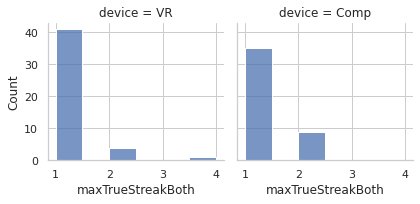

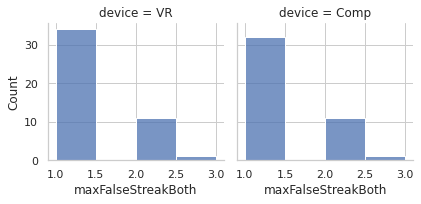

In [40]:

sns.displot(
    scoresDf, x="maxTrueStreakBoth", col="device",
    binwidth=0.5, height=3, facet_kws=dict(margin_titles=True),
)
sns.displot(
    scoresDf, x="maxFalseStreakBoth", col="device",
    binwidth=0.5, height=3, facet_kws=dict(margin_titles=True),
)

# Metadata

### Does previous experience with VR and/or Computer has an impact on the results (positive correlation ?)

In [41]:
combDf=(participantsDf
  .set_index(["participantId"])
  .join(
      scoresDf
      .set_index(["participantId","device"])
      ))

In [42]:
combDf.pop('colorBlind')
combDf.pop('contraindication')
combDf.pop('time')
combDf.pop('TimestampStart')
combDf.pop('TimestampEnd')

participantId  device
16             VR        2022/04/27 1:59:20 PM GMT+2
               VR        2022/04/27 1:59:20 PM GMT+2
13             VR        2022/04/27 3:30:54 PM GMT+2
               VR        2022/04/27 3:30:54 PM GMT+2
               Comp      2022/04/27 3:30:54 PM GMT+2
                                    ...             
15             Comp      2022/05/02 6:36:01 PM GMT+2
               Comp      2022/05/02 6:36:01 PM GMT+2
16             Comp      2022/04/27 1:59:20 PM GMT+2
               Comp      2022/04/27 1:59:20 PM GMT+2
13             Comp      2022/04/27 3:30:54 PM GMT+2
Name: TimestampEnd, Length: 90, dtype: object

In [43]:
combDf = combDf.replace({
    "Less than one week" : 4,
    "Less than one month" : 3,
    "Less than one year" : 2,
    "Less than 3 years" : 1,
    "More than 3 years" : 0,
    "less than 1h in your life" : 0,
    "less than 5h in your life" : 1,
    "less than 10h per year" : 2,
    "less than 3h per month" : 3,
    "less than 6h per week" : 4,
    "On a daily basis" : 5,
    "I have no background knowledge in biology" : 0,
    "I studied biology until middle school" : 1,
    "I studied biology until high school" : 2,
    "I studied biology as an undergrad" : 3,
    "I have a solid background in embryology and developmental biology" : 4,
    "Never used a microscope" : 0,
    "I sporadically used a microscope in school" : 1,
    "I regularly work with microscopic data" : 2,
    "I have already analysed 3d lightsheet microscopic data" : 3,
    "I use 3d lightsheet microscopic data on a regular basis" : 4,
    "Less than 5h per day" : 3,
    "More than 5h per day" : 4})

In [44]:
combDf=combDf.reset_index()

In [45]:
typeDevice =[]
for i in combDf['device']:
  if i == 'VR':
    typeDevice.append(True)
  else:
    typeDevice.append(False)
combDf['isVr']=typeDevice 

didVr=[]
for i in combDf['DidVr']:
  if i == 'Yes':
    didVr.append(True)
  else:
    didVr.append(False)
combDf['DidVr']=didVr 

did3d=[]
for i in combDf['Did3dSoft']:
  if i == 'Yes':
    did3d.append(True)
  else:
    did3d.append(False)
combDf['Did3dSoft']=did3d 

In [46]:
combDf=combDf.set_index(['participantId']).drop(['interaction','activityVr','type3dSoft','device','language','nbTrue'], axis=1)

In [47]:
combDf=combDf.fillna(0)

In [48]:
pDf=np.zeros((len(combDf.columns),len(combDf.columns)))
cDf=np.zeros((len(combDf.columns),len(combDf.columns)))

In [49]:
for i in combDf.columns:
  for j in combDf.columns:
    if ((combDf[i].dtype == bool) | (i=='datasetId')) | ((combDf[j].dtype == bool) | (j=='datasetId')) :
      r, p = stats.pointbiserialr(combDf[i], combDf[j])
    else:
      r, p = stats.pearsonr(combDf[i], combDf[j])
    cDf[combDf.columns.get_loc(i)][combDf.columns.get_loc(j)] = round(r, 2)
    pDf[combDf.columns.get_loc(i)][combDf.columns.get_loc(j)] = round(p, 2)

cDf=pd.DataFrame(cDf)
pDf=pd.DataFrame(pDf)

In [50]:
combDf

,DidVr,lastTimeVr,timeVr,expectedImpactVr,experienceBio,expericenceMicro,timeComp,Did3dSoft,time3dSoft,moveVr,...,maxTrueStreak,maxTrueStreakBoth,maxFalseStreakBoth,veracityScore,levenDist,pauseTime,sortingTime,experimentOrder,sequenceOrder,isVr
participantId,,,,,,,,,,,,,,,,,,,,,
16,True,2.0,1.0,4,2,1,4,False,0.0,4.0,...,1,1,1,0.653061,5,184.909470,269.096130,3,False,True
16,True,2.0,1.0,4,2,1,4,False,0.0,4.0,...,1,1,1,0.244898,7,342.400177,221.314514,4,True,True
13,True,3.0,3.0,4,2,1,4,True,1.0,5.0,...,1,1,1,0.387755,5,34.628632,304.130951,1,False,True
13,True,3.0,3.0,4,2,1,4,True,1.0,5.0,...,1,1,1,0.530612,5,162.141891,227.080627,2,True,True
13,True,3.0,3.0,4,2,1,4,True,1.0,5.0,...,1,1,3,0.224490,7,370.547791,247.132828,3,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,True,3.0,1.0,3,2,1,3,True,1.0,5.0,...,1,1,1,0.326531,7,9.416518,210.855438,3,False,False
15,True,3.0,1.0,3,2,1,3,True,1.0,5.0,...,1,1,1,0.346939,7,6.016559,131.948090,4,True,False
16,True,2.0,1.0,4,2,1,4,False,0.0,4.0,...,1,2,1,0.591837,6,6.350022,250.443741,1,False,False


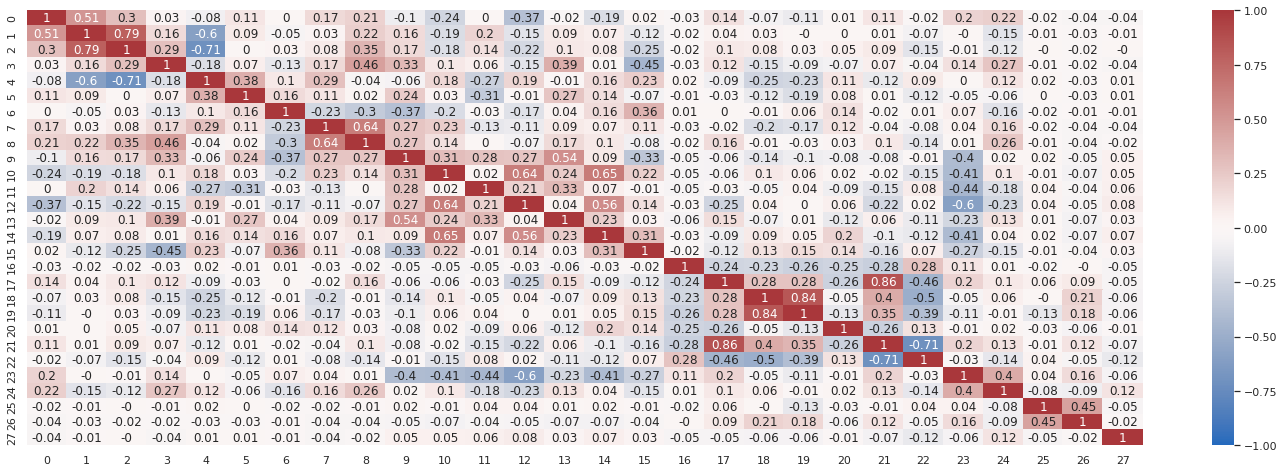

In [51]:
plt.figure(figsize = (25,8))
sns.heatmap(cDf, annot=True, cmap = "vlag",vmin=-1,vmax=1)

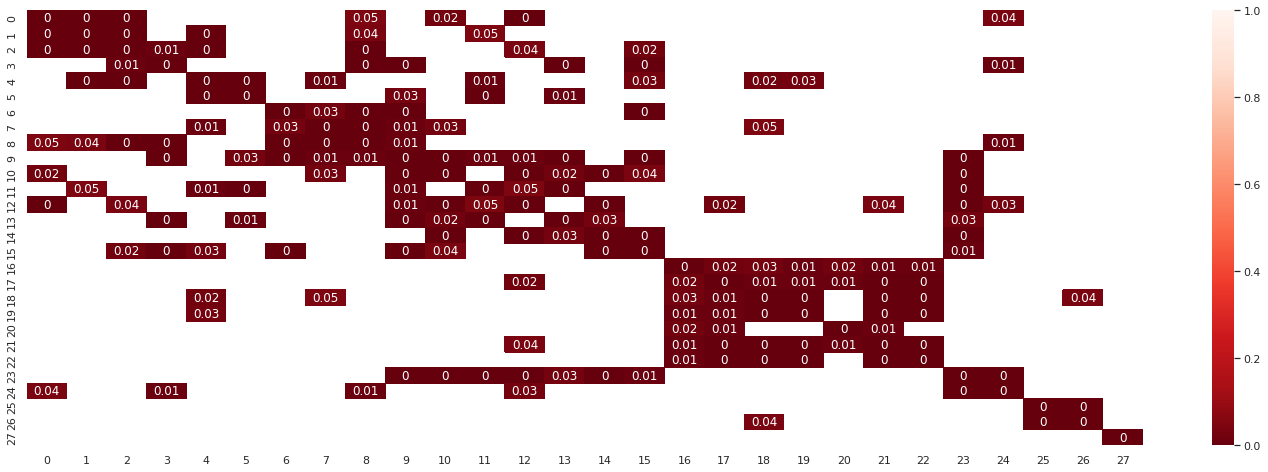

In [52]:
plt.figure(figsize = (25,8))
sns.heatmap(pDf, annot=True, cmap = "Reds_r",vmin=0,vmax=1, mask=pDf>0.05)

In [53]:
def mask(df):
  df = pDf.copy()
  return df

In [54]:
columns = ['Did VR in their life', 'Last time they did VR', 'Time they have spent in VR', 'Expected Impact of VR', 'Experience in Biology',
       'Expericence in Microscopy', 'Time spent on Computer', 'Used 3D Software in their life', 'Timespent on 3D Soft', 'Ease of move in VR',
       'Ease of move in Comp', 'Ease of dataset manip VR', 'Ease of dataset manip Comp', 'Concentration during VR exp',
       'Concentration during Comp exp', 'Which device was easier', 'Dataset seen', 'Thruth proportion',
       'Maximum True shapes Streak', 'Maximum False shapes Streak', 'Veracity Score', 'Levenshtein Distance',
       'Overall Pause duration', 'Sorting duration', 'Experiment Order', 'Order per device', 'Use of VR in experiment']

In [55]:
cDf

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.00,0.51,0.30,0.03,-0.08,0.11,0.00,0.17,0.21,-0.10,...,-0.07,-0.11,0.01,0.11,-0.02,0.20,0.22,-0.02,-0.04,-0.04
1,0.51,1.00,0.79,0.16,-0.60,0.09,-0.05,0.03,0.22,0.16,...,0.03,-0.00,0.00,0.01,-0.07,-0.00,-0.15,-0.01,-0.03,-0.01
2,0.30,0.79,1.00,0.29,-0.71,0.00,0.03,0.08,0.35,0.17,...,0.08,0.03,0.05,0.09,-0.15,-0.01,-0.12,-0.00,-0.02,-0.00
3,0.03,0.16,0.29,1.00,-0.18,0.07,-0.13,0.17,0.46,0.33,...,-0.15,-0.09,-0.07,0.07,-0.04,0.14,0.27,-0.01,-0.02,-0.04
4,-0.08,-0.60,-0.71,-0.18,1.00,0.38,0.10,0.29,-0.04,-0.06,...,-0.25,-0.23,0.11,-0.12,0.09,0.00,0.12,0.02,-0.03,0.01
5,0.11,0.09,0.00,0.07,0.38,1.00,0.16,0.11,0.02,0.24,...,-0.12,-0.19,0.08,0.01,-0.12,-0.05,-0.06,0.00,-0.03,0.01
6,0.00,-0.05,0.03,-0.13,0.10,0.16,1.00,-0.23,-0.30,-0.37,...,-0.01,0.06,0.14,-0.02,0.01,0.07,-0.16,-0.02,-0.01,-0.01
7,0.17,0.03,0.08,0.17,0.29,0.11,-0.23,1.00,0.64,0.27,...,-0.20,-0.17,0.12,-0.04,-0.08,0.04,0.16,-0.02,-0.04,-0.04
8,0.21,0.22,0.35,0.46,-0.04,0.02,-0.30,0.64,1.00,0.27,...,-0.01,-0.03,0.03,0.10,-0.14,0.01,0.26,-0.01,-0.04,-0.02
9,-0.10,0.16,0.17,0.33,-0.06,0.24,-0.37,0.27,0.27,1.00,...,-0.14,-0.10,-0.08,-0.08,-0.01,-0.40,0.02,0.02,-0.05,0.05


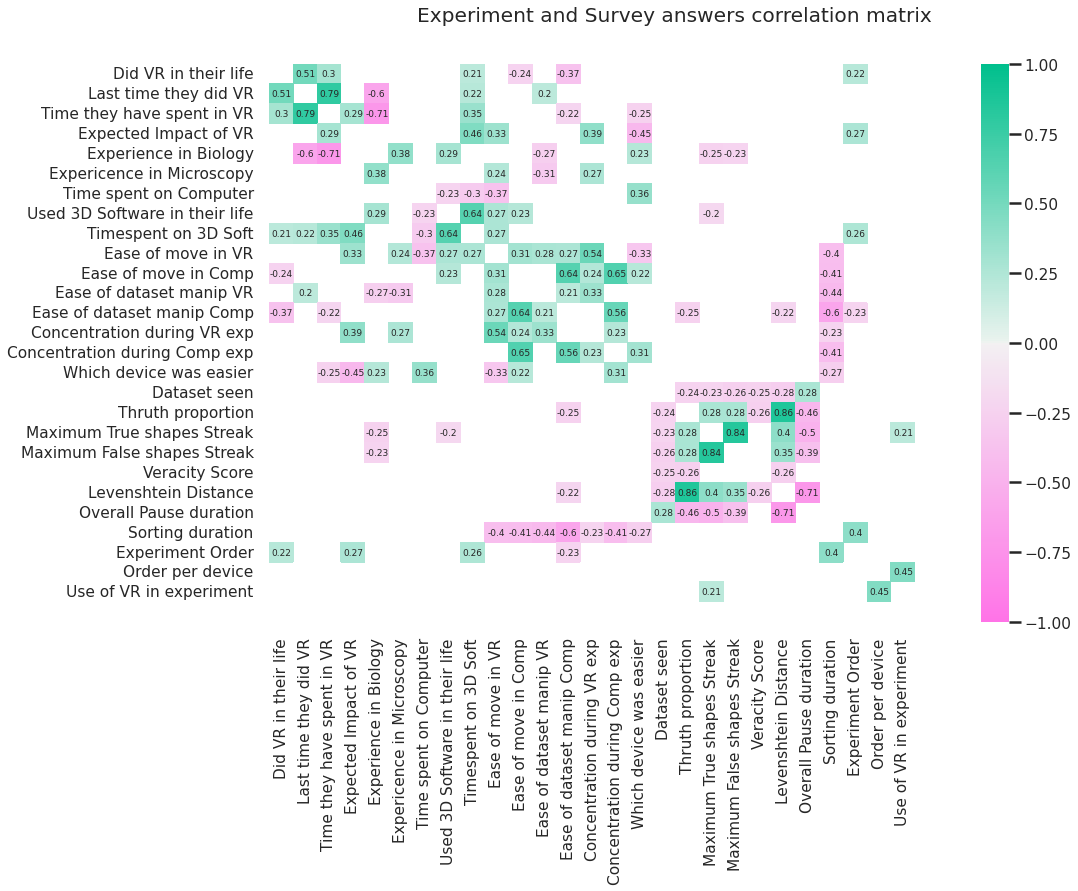

In [56]:
sns.set_context("poster",0.7)
palette=sns.diverging_palette(318, 154, 100, 69, center='light', as_cmap=True)
plt.figure(figsize = (15,10))
g = sns.heatmap(cDf, annot=True, cmap = palette,vmin=-1,vmax=1, mask=(mask(cDf)>0.05) | (cDf==1) , xticklabels=columns, yticklabels=columns, annot_kws={"size": 9})
plt.subplots_adjust(top=0.9)
plt.suptitle('Experiment and Survey answers correlation matrix')
plt.savefig('Correlmap-final.svg')

### How does evolve both type of score depending on the time paused ? 
--> Scatterplot ? 

In [57]:
np.arange(0, max(scoresDf['sortingTime']), 30)

array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
       330., 360., 390., 420., 450., 480., 510., 540., 570., 600., 630.,
       660.])

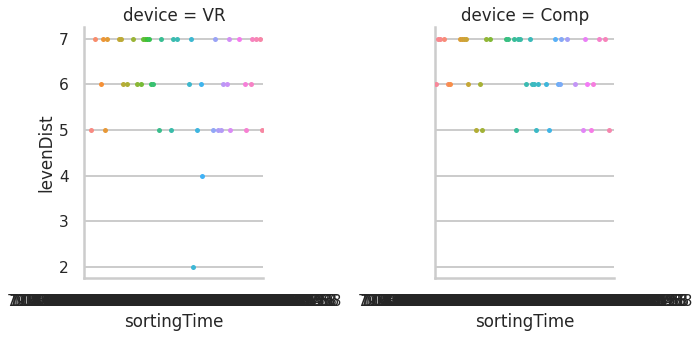

In [58]:
g = sns.catplot(x="sortingTime", y="levenDist", col="device", data=scoresDf)

### Overall, which factor has the most weight in scoring ? What is that of the hardware used ? 
--> Factor plot (Heatmap)

Correlation results

In [59]:
typeDevice =[]
for i in scoresDf['device']:
  if i == 'VR':
    typeDevice.append(True)
  else:
    typeDevice.append(False)

In [60]:
scoresDf["isVr"] = typeDevice

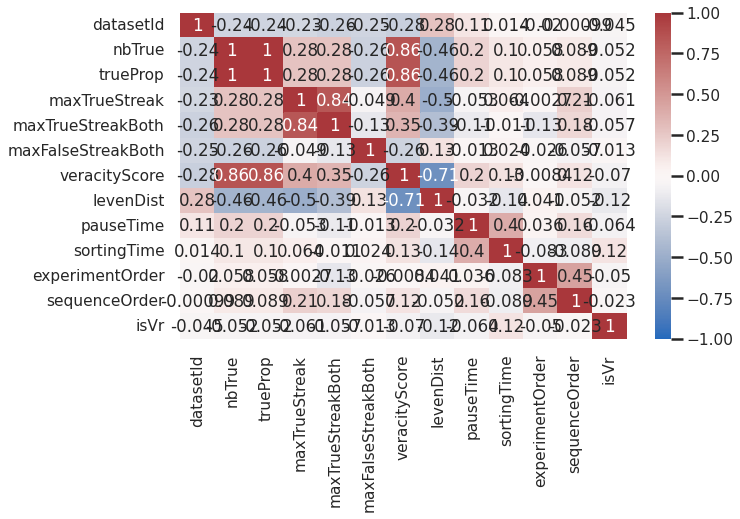

In [61]:
plt.figure(figsize = (10,6))
scoreCorrMatrix=scoresDf.set_index(['participantId']).corr()
sns.heatmap(scoreCorrMatrix, annot=True, cmap = "vlag",vmin=-1,vmax=1)